# Multi-Class Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 7
### David Lowe
### July 13, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) The data set contains three classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other two; the latter are NOT linearly separable from each other.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 80.36% after 50 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 97.36%. Furthermore, the final model processed the test dataset with an accuracy measurement of 97.36%, which was consistent with the training/tuning result.]

CONCLUSION: For this dataset, the model built using TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-class classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/machine-learning-databases/iris/]

One potential source of performance benchmarks: [https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 16

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

Num GPUs Available:  0


In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = "arn:aws:sns:us-east-1:072417399597:PythonMLScriptNotification"
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [12]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [13]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
colNames = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'targetVar']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, na_values=['?'])

# Take a peek at the dataframe after the import
Xy_original.head(10)

,sepal_length,sepal_width,petal_length,petal_width,targetVar
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   targetVar     150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [15]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.b) Data Cleaning

In [17]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with Y/N levels into categorical feature of 1/0
# def reClassSomecol(target):
#     if (target == 'Y'): return 1
#     else: return 0
# Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
# Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,sepal_length,sepal_width,petal_length,petal_width,targetVar
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   targetVar     150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [19]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [20]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.c) Feature Scaling and Pre-processing

In [21]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (150, 5) X_original.shape: (150, 4) y_original.shape: (150,)


In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

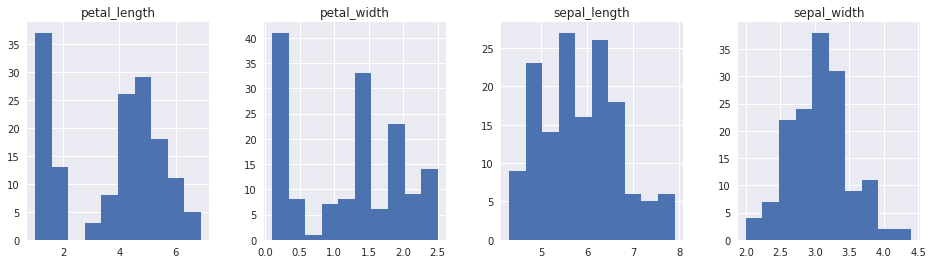

In [24]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_original.columns[X_original.dtypes == 'float64'].tolist()
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [25]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])
print(X_original.head())

Columns to scale are: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
   sepal_length  sepal_width  petal_length  petal_width
0     -0.900681     1.032057     -1.341272    -1.312977
1     -1.143017    -0.124958     -1.341272    -1.312977
2     -1.385353     0.337848     -1.398138    -1.312977
3     -1.506521     0.106445     -1.284407    -1.312977
4     -1.021849     1.263460     -1.341272    -1.312977


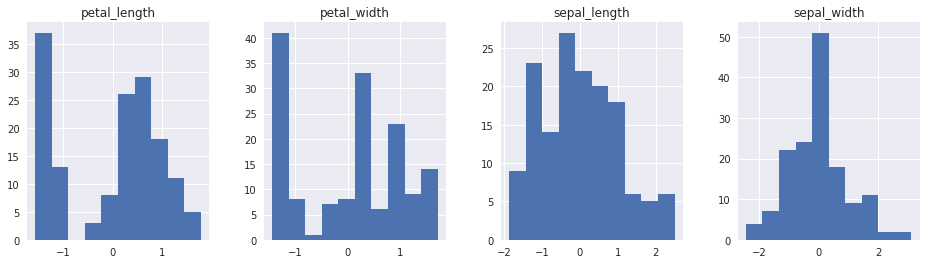

In [26]:
# Histograms for each attribute after pre-processing
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

## 2.d) Splitting Data into Training and Test Sets

In [27]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [28]:
# Encode class values as integers and perform one-hot-encoding
# y_encoded = y_original.to_numpy()
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_transformed = encoder.transform(y_original)
y_encoded = tf.keras.utils.to_categorical(y_transformed)
print(y_encoded[0:19])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [29]:
X_encoded = X_original.to_numpy()
if (splitDataset):
    X_train, X_validation, y_train, y_validation = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_validation, y_validation = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_validation.shape: {} X_validation.type: {}".format(X_validation.shape, type(X_validation)))
print("y_validation.shape: {} y_validation.type: {}".format(y_validation.shape, type(y_validation)))

X_train.shape: (112, 4) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (112, 3) y_train.type: <class 'numpy.ndarray'>
X_validation.shape: (38, 4) X_validation.type: <class 'numpy.ndarray'>
y_validation.shape: (38, 3) y_validation.type: <class 'numpy.ndarray'>


In [30]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [31]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [32]:
# Define the baseline model for benchmarking
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(10, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(3, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [33]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/50
7/7 [==============================] - 0s 2ms/step - loss: 1.2393 - accuracy: 0.2679
Epoch 2/50
7/7 [==============================] - 0s 2ms/step - loss: 1.1864 - accuracy: 0.3125
Epoch 3/50
7/7 [==============================] - 0s 2ms/step - loss: 1.1369 - accuracy: 0.4018
Epoch 4/50
7/7 [==============================] - 0s 2ms/step - loss: 1.0891 - accuracy: 0.4375
Epoch 5/50
7/7 [==============================] - 0s 2ms/step - loss: 1.0469 - accuracy: 0.4643
Epoch 6/50
7/7 [==============================] - 0s 2ms/step - loss: 1.0051 - accuracy: 0.4911
Epoch 7/50
7/7 [==============================] - 0s 4ms/step - loss: 0.9657 - accuracy: 0.5357
Epoch 8/50
7/7 [==============================] - 0s 2ms/step - loss: 0.9299 - accuracy: 0.5804
Epoch 9/50
7/7 [==============================] - 0s 2ms/step - loss: 0.8956 - accuracy: 0.6071
Epoch 10/50
7/7 [==============================] - 0s 2ms/step - loss: 0.8661 - accuracy: 0.6161
Epoch 11/50
7/7 [======================

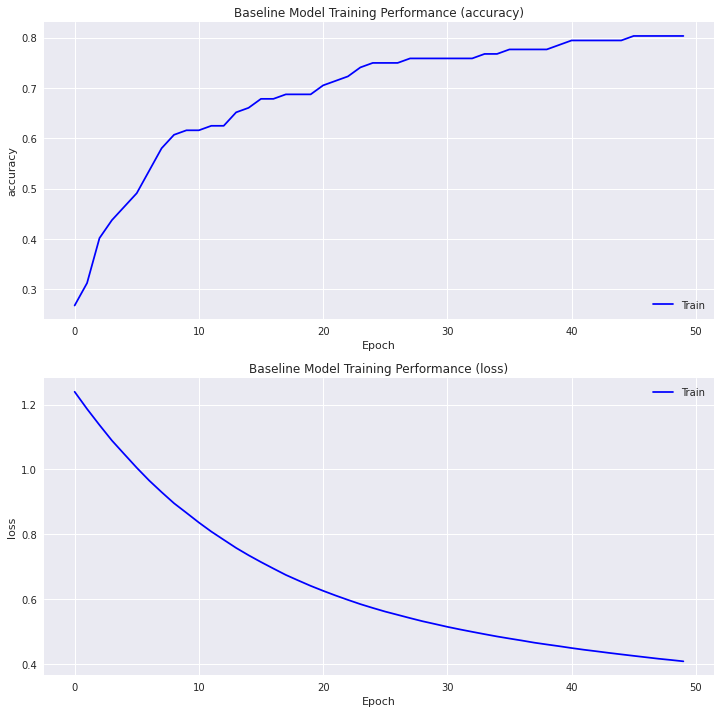

In [34]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history[train_metric], color='blue', label='train')
plt.title('Baseline Model Training Performance (%s)' % (train_metric))
plt.ylabel(train_metric)
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.subplot(212)
plt.plot(baseline_hist.history[train_loss], color='blue', label='train')
plt.title('Baseline Model Training Performance (%s)' % (train_loss))
plt.ylabel(train_loss)
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [35]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [36]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(10, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(3, activation='softmax', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [38]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [int(default_batch/2), default_batch, int(default_batch*2)]

best_score = 0
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, 
                                       validation_data=(X_validation, y_validation), verbose=1)
                if(grid_hist.history['val_accuracy'][-1] > best_score):
                    best_score = grid_hist.history['val_accuracy'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (highest validation accuracy) found via grid search: accuracy=%f from model iteration #%d"
      % (best_score, best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff4a8a3bc10>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7ff4984b7c90>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7ff4984b7c50>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7ff4984b9190>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7ff4984b9390>
Initializer candidate #3 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7ff4984b9490>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff4a8a3bc10>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7ff4984b9190>, epochs=50, batch_size=8
Epoch 1/50
14/14 [==============

In [39]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [40]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
final_optimizer = best_optimizer
final_kernel_init = best_kernel_init
final_epoch = best_epoch
final_batch = best_batch

In [42]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (final_optimizer, final_kernel_init, final_epoch, final_batch))
reset_random(seedNum)
final_model = create_customized_model(final_optimizer, final_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=final_epoch, batch_size=final_batch, validation_data=(X_validation, y_validation), verbose=1)

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff4a8a3bc10>, kernel=<tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7ff4984b9390>, epochs=50, batch_size=8
Epoch 1/50
14/14 [==============================] - 0s 23ms/step - loss: 1.1041 - accuracy: 0.4286 - val_loss: 0.8797 - val_accuracy: 0.8158
Epoch 2/50
14/14 [==============================] - 0s 7ms/step - loss: 0.8251 - accuracy: 0.7411 - val_loss: 0.6357 - val_accuracy: 0.8684
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6467 - accuracy: 0.7768 - val_loss: 0.5073 - val_accuracy: 0.8684
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5459 - accuracy: 0.7857 - val_loss: 0.4311 - val_accuracy: 0.8684
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.4853 - accuracy: 0.7946 - val_loss: 0.3783 - val_accuracy: 0.8684
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.4429 

In [43]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_57 (Dense)             (None, 3)                 33        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_28', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_56', 'trainable': True, 'batch_input_shape': (None, 4), 'dtype': 'float32', 'units': 10, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_57', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}], 'build_input_shape': TensorShape([None, 4])}


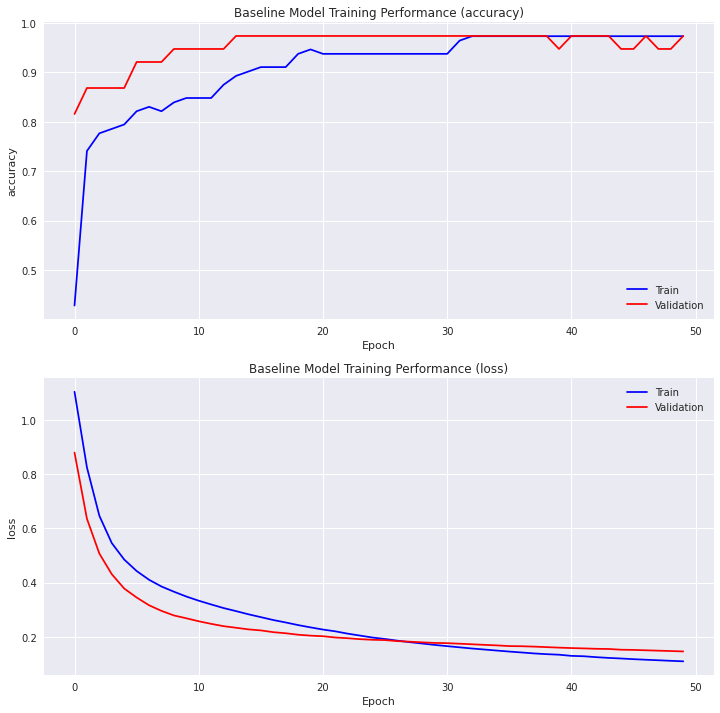

In [45]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(final_hist.history[train_metric], color='blue', label='train')
plt.plot(final_hist.history[validation_metric], color='red', label='validation')
plt.title('Baseline Model Training Performance (%s)' % (train_metric))
plt.ylabel(train_metric)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.subplot(212)
plt.plot(final_hist.history[train_loss], color='blue', label='train')
plt.plot(final_hist.history[validation_loss], color='red', label='validation')
plt.title('Baseline Model Training Performance (%s)' % (train_loss))
plt.ylabel(train_loss)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [46]:
# In the absence of a brand new test dataset, we will use the same validation dataset as a substitute
X_test = X_validation
y_test = y_validation

In [47]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %f" % (final_model.metrics_names[0], scores[0]))

2/2 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9737

accuracy: 97.368419%

loss: 0.146267


In [48]:
# Make class predictions with the model
predictions = np.argmax(final_model.predict(X_test), axis=-1)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]])[0], encoder.inverse_transform([np.argmax(y_test[i])])[0]))

Data item #0 predicted to be Iris-setosa (expected Iris-setosa)
Data item #1 predicted to be Iris-setosa (expected Iris-setosa)
Data item #2 predicted to be Iris-setosa (expected Iris-setosa)
Data item #3 predicted to be Iris-versicolor (expected Iris-versicolor)
Data item #4 predicted to be Iris-virginica (expected Iris-virginica)
Data item #5 predicted to be Iris-virginica (expected Iris-virginica)
Data item #6 predicted to be Iris-setosa (expected Iris-setosa)
Data item #7 predicted to be Iris-setosa (expected Iris-setosa)
Data item #8 predicted to be Iris-versicolor (expected Iris-versicolor)
Data item #9 predicted to be Iris-setosa (expected Iris-setosa)
Data item #10 predicted to be Iris-versicolor (expected Iris-versicolor)
Data item #11 predicted to be Iris-versicolor (expected Iris-versicolor)
Data item #12 predicted to be Iris-virginica (expected Iris-versicolor)
Data item #13 predicted to be Iris-setosa (expected Iris-setosa)
Data item #14 predicted to be Iris-virginica (exp

In [49]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:00.964609
